## Домашнее задание

- Выбрать ряд и построить его модель ARIMA/GARCH.
- Спрогнозировать график классическим ML (необязательно).

In [43]:
from arch import arch_model
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Dickey-Fuller test
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dfoutput['p-value']

In [9]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
        plt.show()
    return

**Будем рассматривать временной ряд *`Monthly sales of company X`***

In [13]:
# prepairing data
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")

all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"]
}

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


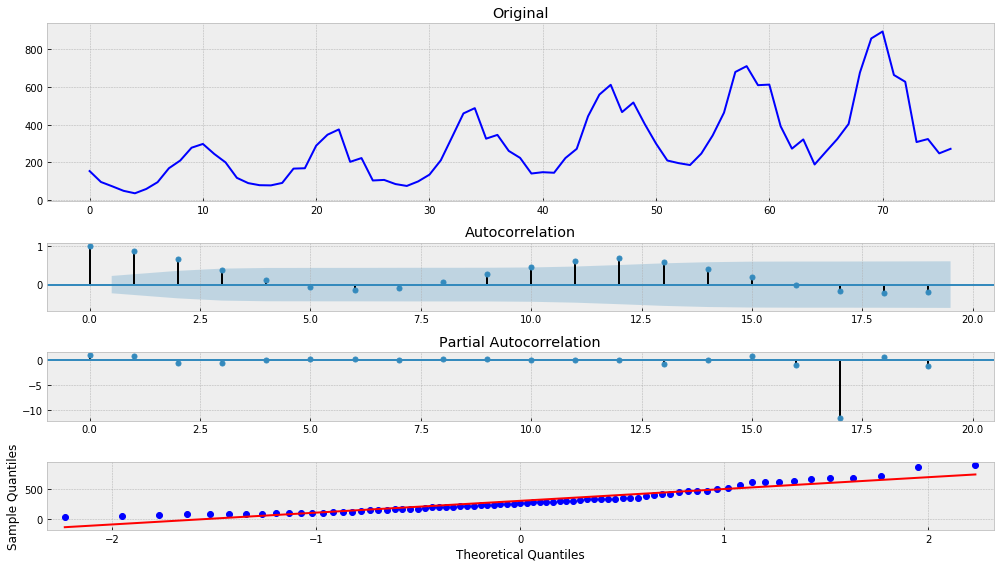

In [36]:
unstationary_series = list(all_series.values())[0]
tsplot(unstationary_series)

In [37]:
def stationate_series(series):    
    series = boxcox(series, 0)
#     series = series[1:] - series[:-1]
#     series = series[12:] - series[:-12]
    return series

Results of Dickey-Fuller Test:
Test Statistic                 -0.908049
p-value                         0.785310
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


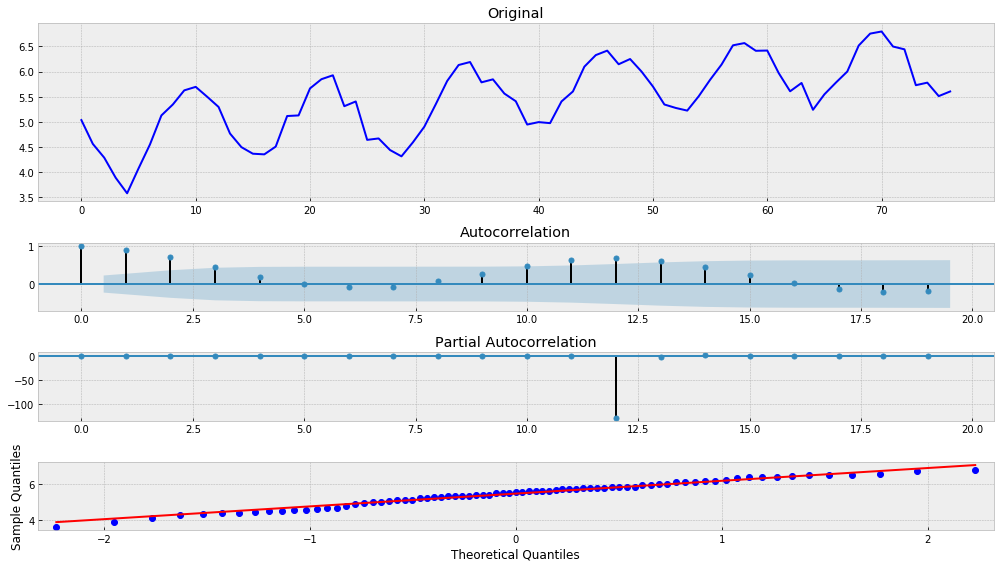

In [49]:
series = stationate_series(unstationary_series)
tsplot(stationary_series)

**Применим к выбранному ряду *ARIMA***

In [44]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [48]:
aic, order, mdl = _get_best_model(series)

aic: -33.21456 | order: (3, 1, 2)


Results of Dickey-Fuller Test:
Test Statistic                -9.171939e+00
p-value                        2.375398e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


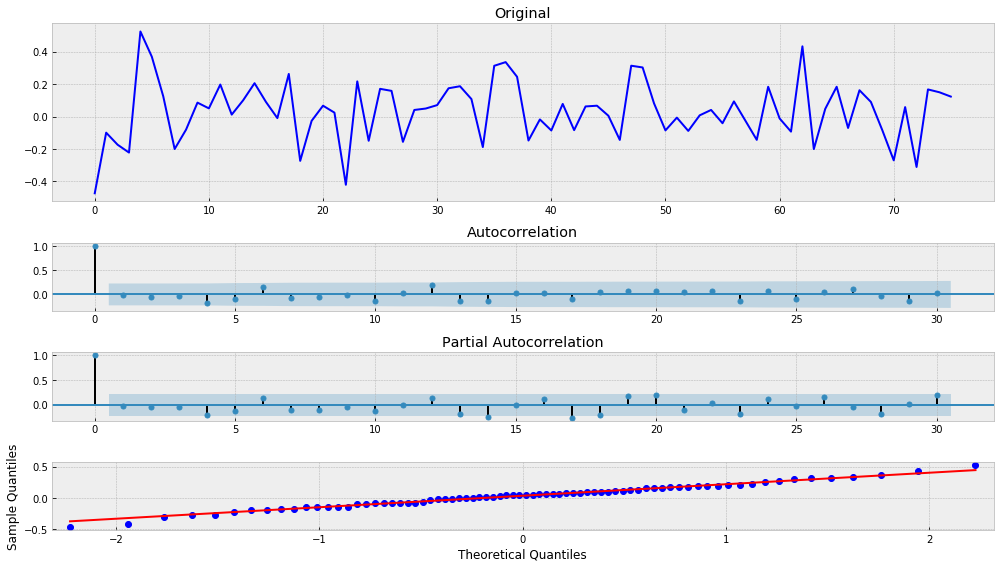

In [46]:
tsplot(mdl.resid, lags=30)

In [47]:
print(mdl.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   76
Model:                 ARIMA(3, 1, 2)   Log Likelihood                  22.607
Method:                           mle   S.D. of innovations              0.172
Date:                Tue, 28 Apr 2020   AIC                            -33.215
Time:                        20:23:18   BIC                            -19.230
Sample:                             1   HQIC                           -27.626
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.D.y      1.1824      0.101     11.750      0.000       0.985       1.380
ar.L2.D.y     -0.0464      0.173     -0.268      0.789      -0.385       0.293
ar.L3.D.y     -0.5480      0.100     -5.501      0.0

**Применим к ряду *GARCH***

In [50]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [52]:
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(series, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     64,   Neg. LLF: -1.2121684472182925
Iteration:     10,   Func. Count:    119,   Neg. LLF: -1.702512154272382
Iteration:     15,   Func. Count:    174,   Neg. LLF: -1.7385412364914186
Iteration:     20,   Func. Count:    229,   Neg. LLF: -1.7874322904989925
Iteration:     25,   Func. Count:    289,   Neg. LLF: -1.7915492566676945
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.7915703472729196
            Iterations: 26
            Function evaluations: 311
            Gradient evaluations: 26
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                            y   R-squared:                      -0.005
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.005
Vol Model:                        GJR-GARCH   Log-Likelihood:                1.79157
Distribution:      Standardized Student's t   AIC:                           1

Results of Dickey-Fuller Test:
Test Statistic                 -2.316045
p-value                         0.166845
#Lags Used                     10.000000
Number of Observations Used    53.000000
Critical Value (1%)            -3.560242
Critical Value (5%)            -2.917850
Critical Value (10%)           -2.596796
dtype: float64


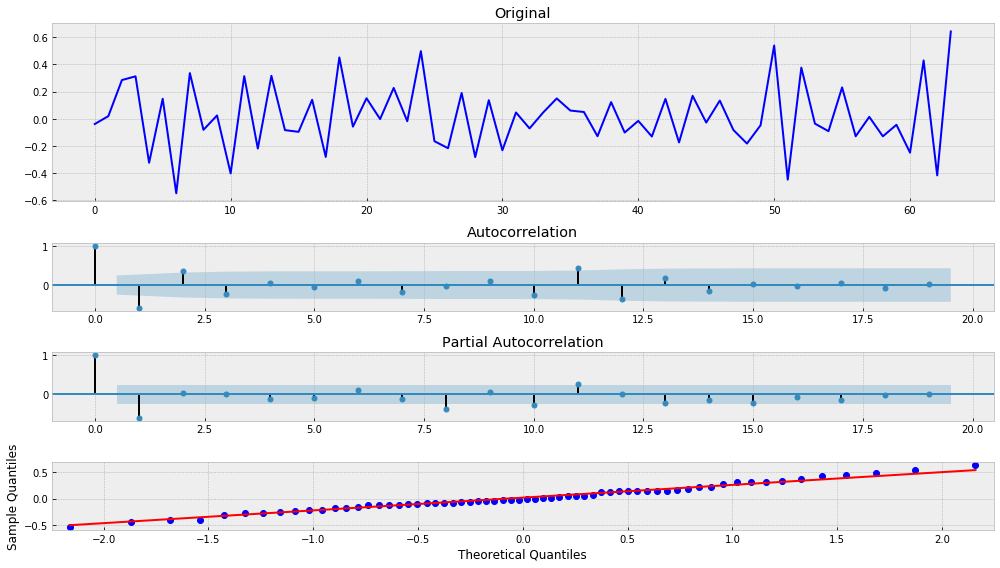

In [53]:
tsplot(res.resid)

**Прогнозирование графика с использованием *`DecisionTreeRegressor`* (необязательное задание)**

In [110]:
series = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")

In [111]:
series.head()

,Month,Count
0,1965-01,154
1,1965-02,96
2,1965-03,73
3,1965-04,49
4,1965-05,36


In [155]:
def prepareData(data, lag_start=5, lag_end=50, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
    
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
            
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
        
    return X_train, X_test, y_train, y_test

In [156]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=14, test_size=0.3)

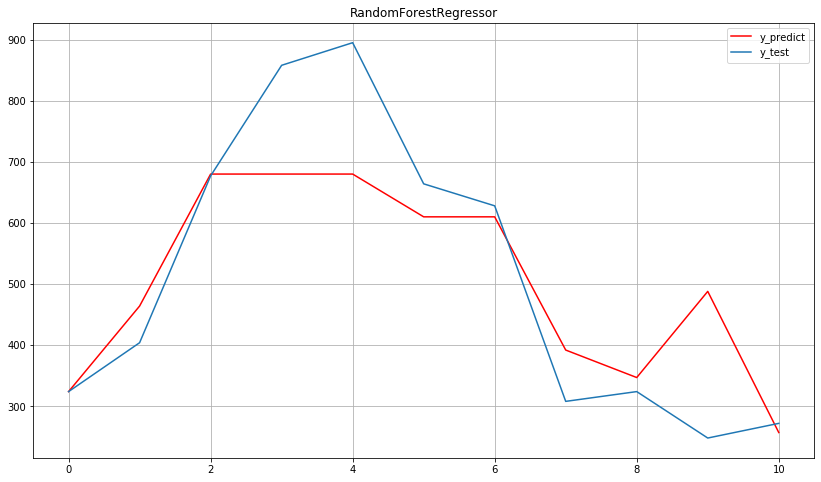

In [157]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
y_predict = dt.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(y_predict, "r", label="y_predict")
plt.plot(y_test.values, label="y_test")
plt.legend(loc="best")
plt.title("RandomForestRegressor")
plt.grid(True)
plt.show()